# Training on labeled data - boosted classifiers

Here we train only the subset of ```train.csv``` that contains the ```sii``` labels on a few boosted classifier algorithms (XGBoost, CatBoost and LightGBM). For a simple analysis, we do not incorporate the actigraphy data. In this notebook, we perform the following tasks-
1. **Data preprocessing:** The training data with ```sii``` is separated out and the numerical and categorical columns are processed separately. Since some of the numerical features have very large outliers, they are *winsorized*. During the processing, the numerical and categorical features are imputed using various strategies (simple, knn and iterative).
2. **Hyperparameter tuning:** GridSearchCV and ShuffleSplit are used on the training data with various estimators to obtain the optimal hyperparameters.

In [83]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm 
from sklearn.base import clone 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, cohen_kappa_score

In [8]:
folder_path = './../child-mind-institute-problematic-internet-use/'

train_df = pd.read_csv(folder_path + 'train.csv', index_col='id')
test_df = pd.read_csv(folder_path + 'test.csv', index_col='id')
data_dict = pd.read_csv(folder_path + 'data_dictionary.csv')

The test set has fewer attributes than training. Other than ```sii```, it is also missing the different ```PCIAT``` columns. This makes sense since the ```sii``` scores are possibly based on the ```PCIAT``` scores and the task of the learning model is to use other factors to predict the score.

In [11]:
train_cols = train_df.columns.tolist()
test_cols = test_df.columns.tolist()

set(train_cols) - set(test_cols) # the difference between two lists can be taken if converted to sets

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

## Preprocessing

We first remove the different ```PCIAT``` columns from the training dataset. Then, we consider the subset of the data that has ```sii``` values associated with them. The numerical and categorical columns are then separated out. Here, the categorical columns are those features which are labeled as ```categorical int``` in ```data_dictionary.csv```.

In [12]:
drop_cols = list(set(train_cols) - set(test_cols)) # columns for dropping from training set
drop_cols.remove('sii')

''' 
Selecting the subset that contains 'sii' labels and create X_train and y (labels)
'''
train_df_subset = train_df[train_df.loc[:, 'sii'].notna()]
train_df_subset.drop(columns=drop_cols, inplace=True)

X_train = train_df_subset.iloc[:, 0:-1]
y = train_df_subset.loc[:, 'sii'].astype('int')
X_test = test_df 

We separate out the numerical and categorical columns using the ```Type``` field in the ```data_dictionary.csv``` file, where the categorical features are solely those that are labeled as ```categorical int``` in ```data_dictionary.csv```. However, we note that ```PCIAT-PCIAT_Total``` field must be manually removed. Furthermore, we drop the different 'Enrolment Season' columns.

In [18]:
numerical_cols = data_dict[
    (data_dict['Type']=='float') | (data_dict['Type']=='int')
]['Field'].tolist()
numerical_cols.remove('PCIAT-PCIAT_Total')
numerical_cols = [item for item in numerical_cols if (item not in drop_cols)]

categorical_cols = data_dict[data_dict['Type']=='categorical int']['Field'].tolist() 

categorical_cols = [item for item in categorical_cols if (item not in drop_cols)] # this contains PCIAT; needs to be removed

In [19]:
print(numerical_cols)
print(f'There are {len(numerical_cols)} numerical features.')

['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']
There are 37 numerical features.


In [20]:
print(categorical_cols)
print(f'There are {len(categorical_cols)} categorical features.')

['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']
There are 11 categorical features.


### Useful functions

We define some useful functions here. 
1. ```clipped(X, r)```: This function takes in the numerical columns of the training data as input and winsorizes only those columns for which the standard deviation is much greater than the mean, expressed as the ratio $r$.
2. ```processing(X)```: This function takes the training dataset ```X```, splits it into numerical and categorical features and performs the necessary processing steps. These include winsorization, replacing occurrences of zeros with means and imputation. For imputation, we tested between ```KNNImputer()``` and ```IterativeImputer()```, where we found that the former generally performs better with ```n_neighbors=2```.
3. ```ParamSearchModels(X, y)```: This function takes in the processed data and performs ```ShuffleSplit()``` and ```GridSearchCV``` for the estimators (LightGBM, CatBoost and XGBoost) and parameter sets specified.

In [91]:
def clipped(X, r):
    ''' 
    This function caps the numerical columns to the specified upper and lower quantiles on respective ends. It does so for those featutres
    for which the standard deviation is much greater or equal the mean. This is passed as a desired ratio of std/mean.
    '''
    X_clipped = X.copy()

    ratio = X_clipped.std() / X_clipped.mean()
    idx_list = ratio[ ratio.where(ratio >= r).notna() ].index.tolist()

    for idx in idx_list:
        lq = X_clipped[idx].quantile(0.05)
        uq = X_clipped[idx].quantile(0.95)
        X_clipped[idx].clip(lower=lq, upper=uq, inplace=True)

    return X_clipped

def processing(X):
    ''' 
    The training data is first split into numerical and categorical features.
    '''
    X_numerical = X[numerical_cols]

    X_categorical = X[categorical_cols]

    # Some numerical features have erroneous zero values - e.g. BMI, blood pressure etc
    # Winsorize X_numerical and replace occurrences of zero with feature mean

    X_numerical = clipped(X_numerical, 1.5)
    X_numerical.replace(0, X_numerical.mean(axis=0), inplace=True)

    ''' 
    Here we perform imputation and standardization. The 'sex' column is not explicitly one-hot encoded since it is a
    binary feature. Both categorical and numerical columns are imputed through some appropriate means (not specified here
    since it can change).

    The numerical columns are also standardized using the StandardScaler().
    '''

    # Since the sex column is binary, we are not performing one-hot encoding on it.
    ct = ColumnTransformer(
        transformers=[
            ('imp_cat', KNNImputer(n_neighbors=2, weights='uniform'), categorical_cols[1:])
        ], remainder='passthrough' 
    )

    ct.set_output(transform='pandas')
    X_categorical = ct.fit_transform(X_categorical)
    X_categorical = X_categorical.astype('int')

    pipeline = Pipeline(
        [
            ('imp_num',  KNNImputer(n_neighbors=2, weights='uniform')),
            #('imp_num', IterativeImputer(max_iter=10, random_state=1, sample_posterior=True)),
            #('imp_num', SimpleImputer()),
            ('ss', StandardScaler())
        ]
    )
    pipeline.set_output(transform='pandas')
    X_numerical = pipeline.fit_transform(X_numerical)

    X_processed = X_categorical.join(X_numerical)

    return X_processed


def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def ParamSearchModels(X, y):

    algorithms = {
        'LightGBM': {
            'model'    : LGBMClassifier(),
            'params'   : {
                'n_estimators' : [100, 200],
                'max_depth'    : [5, 10, 15],
                'learning_rate': [0.01, 0.1],
                'drop_rate'    : [0.25, 0.5],
                'verbose'      : [-1] 
            }
        },
        
        'CatBoost' : {
            'model' : CatBoostClassifier(verbose=False),
            'params' : {
                'iterations' : [200],
                'learning_rate' : [0.001, 0.01, 0.1],
                'depth'         : [10],
                'l2_leaf_reg'   : [3, 5, 10]    
            }
            
        },
        'XGBoost' : {
            'model'    : XGBClassifier(),
            'params'   : {
                'n_estimators' : [50, 100, 150],
                'max_depth'    : [5, 10, 15],
                'subsample'    : [0.5, 0.75],
                'gamma'        : [0.01, 0.05, 0.1],
                'eta'          : [0.001, 0.01, 0.1],
                'lambda'       : [1, 5, 10],
                'alpha'        : [1, 5, 10]
            }
        }
    }

    scores = []
    QWK_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)
    cv = ShuffleSplit(n_splits = 5, test_size=0.2)
    
    for algorithm, config in tqdm(algorithms.items()):
        GS = GridSearchCV( 
            config['model'], 
            config['params'], 
            cv=cv, 
            return_train_score=False,
            scoring = QWK_scorer,
            n_jobs = -1
        )
        GS.fit(X, y)
        scores.append(
            {
                'model'       : algorithm,
                'best_score'  : GS.best_score_,
                'best_params' : GS.best_params_ 
            }
        )

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


def train_model(clf_class, X_train, X_test, y):
    # naming the processing(X_train) as XX to avoid naming conflicts further
    XX = processing(X_train)

    n_splits = 5
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True)
    train_scores = [] # training QWK scores across folds
    val_scores = []   # validation QWK scores across folds

    y_test_pred = np.zeros((len(X_test), n_splits)) # stores predictions across all folds

    ''' 
    Performing Stratified k-fold cross validation with n_splits=5; the training set XX will be further
    split into training and validation sets a total of n_split times
    '''
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(XX, y), desc='Training folds', total=n_splits)):

        # Breaking up the training data into further training and validation sets during each iteration
        XX_train, XX_val = XX.iloc[train_idx], XX.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        clf = clone(clf_class)
        clf.fit(XX_train, y_train)

        y_train_pred = clf.predict(XX_train)
        y_val_pred = clf.predict(XX_val)

        kappa_train = quadratic_weighted_kappa(y_train, y_train_pred)
        kappa_val = quadratic_weighted_kappa(y_val, y_val_pred)

        train_scores.append(kappa_train)
        val_scores.append(kappa_val)

        y_test_pred[:, fold] = clf.predict(processing(X_test))

        print(f'Fold {fold + 1}: Training QWK = {kappa_train:.4f}, Validation QWK: {kappa_val:.4f}')
    
    print(f'Mean training QWK = {np.mean(train_scores):.4f}')
    print(f'Mean validation QWK = {np.mean(val_scores):.4f}')

    y_test_pred_mean = y_test_pred.mean(axis=1)
    #y_output = pd.DataFrame(
    #    {
    #        'id': X_test.index.tolist(),
    #        'sii': y_test_pred
    #    }
    #)

    return train_scores, val_scores, y_test_pred

def make_predictions(estimator, params, X_train, X_test):
    clf = estimator(**params)
    clf.fit(X_train, y)

    y_pred = clf.predict(X_test).tolist()
    test_id = X_test.index.tolist()

    return pd.DataFrame({'id': test_id, 'sii': y_pred})

Performing ```GridSearchCV``` on the three boosted classifiers, we find that the ```XGBClassifier``` performs best.

In [93]:
X_train_processed = processing(X_train)

#GS_params_data = ParamSearchModels(X_train_processed, y)

#GS_params_data

Since the XGBoost and LightGBM classifiers perform the best, we combine these two, along with the generated hyperparameters, in a ```VotingClassifier()``` model with a weight ratio of $[0.25, 0.75]$ favoring XGBoost. This is then cross-validated through Stratified k-fold with training and validation QWK scores generated at each fold. For the final prediction, we use the fold which generates the highest validation score.

In [94]:
params_lgb = {
    'drop_rate': 0.25,
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'verbose': -1
}
params_xgb = {
    'alpha': 1,
    'eta': 0.01,
    'gamma': 0.05,
    'lambda': 1,
    'max_depth': 10,
    'n_estimators': 50,
    'subsample': 0.75
}

lgb_clf = LGBMClassifier(**params_lgb)
xgb_clf = XGBClassifier(**params_xgb)

voting_clf = VotingClassifier(
    estimators=[
        ('LightGBM', lgb_clf),
        ('XGBoost', xgb_clf)
    ],
    weights=[0.25, 0.75]
)

train_scores, val_scores, preds = train_model(voting_clf, X_train, X_test, y)

Training folds:  20%|██        | 1/5 [00:00<00:03,  1.25it/s]

Fold 1: Training QWK = 0.8051, Validation QWK: 0.3407


Training folds:  40%|████      | 2/5 [00:01<00:02,  1.26it/s]

Fold 2: Training QWK = 0.8200, Validation QWK: 0.3415


Training folds:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s]

Fold 3: Training QWK = 0.8160, Validation QWK: 0.3057


Training folds:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Fold 4: Training QWK = 0.7797, Validation QWK: 0.3699


Training folds: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

Fold 5: Training QWK = 0.7991, Validation QWK: 0.3237
Mean training QWK = 0.8040
Mean validation QWK = 0.3363


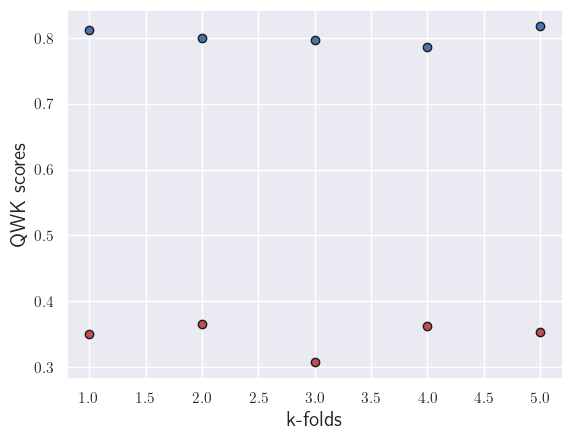

In [73]:
folds = range(1, 6)

plt.scatter(folds, train_scores, c='b', edgecolors='k')
plt.scatter(folds, val_scores, c='r', edgecolors='k')
plt.xlabel('k-folds', fontsize=15)
plt.ylabel('QWK scores', fontsize=15)
plt.show()

In [88]:
val_score_max = max(val_scores)
idx_max = val_scores.index(val_score_max)

y_out = preds[:, idx_max]
output = pd.DataFrame(
    {
        'id': X_test.index.tolist(),
        'sii': y_out  
    }
)

In [90]:
output.to_csv('submission.csv', index=False)